# Pet Classification with CNN
<b>Student</b>: Lorenzo Severini<b>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Course</b>: Computer Vision and Image Processing M

# Project Overview
The goal of this project is to implement a neural network that classifies images of 37 breeds of cats
and dogs from the Oxford-IIIT-Pet dataset. The project is divided into two tasks: first, you will be
asked to implement from scratch your own neural network for image classification; then, you will
fine-tune a pre-trained network provided by Keras.

## Dataset
### Overview
The dataset you will be using contains images of pets.

![dataset overview](img-report/dataset-overview.png "Dataset OVeerview")

You can download the dataset at the following URL: https://www.robots.ox.ac.uk/~vgg/data/pets/.

### Content
The repository contains a 37-category pet dataset with roughly 200 images for each class. The
images have a large variation in scale, pose and lighting. All images have an associated ground
truth annotation of breed. The dataset is already split into training, validation and testing. You
should use only the training and validation splits for development in both the first and second tasks.

# Final Task: assess the performance on the testing set
Assess the performance of your best model from both tasks on the testing set as the final evaluation.

## Environment Setup

We begin by importing the necessary libraries for data manipulation and deep learning.

In [ ]:
import os
import tarfile
import shutil
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

2025-12-19 00:33:21.684300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-19 00:33:21.684519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-19 00:33:21.729203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-19 00:33:21.827049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 00:33:22.923736: W tensorflow/compiler/tf2

## Path Configuration

We define the file paths pointing to the <b>best checkpoints</b> saved during Task 1 (Custom CNN) and Task 2 (ResNet-18 Fine-Tuning).
<b>Paths</b>:
<ul>
    <li><code>task1_best_path</code>: Points to the best custom model achieved in task 1.</li>
    <li><code>task2_p2_best_path</code>: Points to the final fine-tuned ResNet model achieved in task 2 (phase 2).</li>
</ul>

In [ ]:

task1_runs_dir = '../task1/runs/'
task2_runs_dir = '../task2/runs/'

task1_best_dir = os.path.join(task1_runs_dir, 'run_test7_acc63')
task2_best_dir = os.path.join(task2_runs_dir, 'run_task2')

# best model path from both tasks
task1_best_path = os.path.join(task1_best_dir, 'best_model.keras')
task2_p1_best_path = os.path.join(task2_best_dir, 'best_model_part1.keras')
task2_p2_best_path = os.path.join(task2_best_dir, 'best_model_part2.keras')

# best model's history path from both tasks
task1_best_history_path = os.path.join(task1_best_dir, 'best_model_history.csv')
task2_p1_best_history_path = os.path.join(task2_best_dir, 'best_model_history_part1.csv')
task2_p2_best_history_path = os.path.join(task2_best_dir, 'best_model_history_part2.csv')

# path configuration
dataset_dir_path = os.path.join('../', 'oxford-pet')

images_dir_path = os.path.join(dataset_dir_path, 'images')
annots_dir_path = os.path.join(dataset_dir_path, 'annotations')

# defining separate folders for the official splits
train_val_path = os.path.join(dataset_dir_path, 'train_val')
test_path = os.path.join(dataset_dir_path, 'test')

## Dataset Preparation

To ensure the testing environment is consistent with the training phases, we reuse the data download and extraction logic.
<ul>
    <li><b>Verification</b>: Checks if the <i>Oxford-IIIT Pet</i> dataset exists locally.</li>
    <li><b>Splitting</b>: We execute the <code>create_split</code> function to organize the <b>Test Set</b> images into class-specific folders based on the official <code>test.txt</code> file. This allows us to use <code>image_dataset_from_directory</code> for reliable evaluation.</li>
</ul>

In [ ]:
def download_and_extract(url, dest_folder, filename):
    # create the folder if not exists
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    archive_path = os.path.join(dest_folder, filename)
    
    # downloading archive
    print(f"Downloading {filename}...")
    tf.keras.utils.get_file(
        fname=filename,
        origin=url,
        cache_dir='.', 
        cache_subdir=dest_folder # downloads directly into the folder
    )
    
    # extracting (python handles .tar.gz in one step)
    print(f"Extracting {filename}...")
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=dest_folder)
        
    # removing the zip file to clean up
    print(f"Removing {filename} to save space...")
    os.remove(archive_path)

# check if images exist
if not os.path.exists(images_dir_path):
    url_images = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    download_and_extract(url_images, dataset_dir_path, 'images.tar.gz')
else:
    print("Images already present.")

# check if annotations exist
if not os.path.exists(annots_dir_path):
    url_annots = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
    download_and_extract(url_annots, dataset_dir_path, 'annotations.tar.gz')
else:
    print("Annotations already present.")

Images already present.
Annotations already present.


In [ ]:
def create_split(annots_filename, dest_path):
    # path to the list file (e.g. annotations/trainval.txt)
    annots_file_path = os.path.join(annots_dir_path, annots_filename)
    
    # check if destination already exists to avoid re-copying

    if os.path.exists(dest_path):
        print(f"Split {os.path.basename(dest_path)} already exists.")
        return

    print(f"Creating split in {dest_path}...")
    os.makedirs(dest_path, exist_ok=True)
    
    # reading the list file
    with open(annots_file_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        if not parts: continue
            
        # parsing the line: "Abyssinian_1 1 1 1"
        filename_no_ext = parts[0]
        filename = filename_no_ext + ".jpg"
        
        # getting class name (everything before the last underscore)
        # for example, "Abyssinian_1" -> "Abyssinian"
        class_name = "_".join(filename_no_ext.split('_')[:-1])
        
        # defining source and destination paths
        src_file = os.path.join(images_dir_path, filename)
        dest_folder = os.path.join(dest_path, class_name)
        dest_file = os.path.join(dest_folder, filename)
        
        # copy file only if it exists in source
        if os.path.exists(src_file):
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)
            shutil.copy(src_file, dest_file)

# executing the splits
# trainval.txt -> train_val folder
# test.txt -> test folder
if os.path.exists(images_dir_path) and os.path.exists(annots_dir_path):
    create_split('trainval.txt', train_val_path)
    create_split('test.txt', test_path)
    print("Dataset splitting complete.")
else:
    print("ERROR: images or annotations not found. Run the download block first.")

Split train_val already exists.
Split test already exists.
Dataset splitting complete.


## Visualization Utility

I defined a helper function <code>plot_best_model</code> to visualize the training history saved in the CSV logs.
<ul>
    <li><b>Functionality</b>: It reads the training log and plots two graphs: <b>Loss over Epochs</b> and <b>Accuracy over Epochs</b>.</li>
    <li><b>Best Epoch Tracking</b>: It automatically identifies and highlights the epoch with the lowest <code>val_loss</code> (marked with a red dot), printing the exact metrics for that specific point. This helps in quickly assessing the model's peak performance.</li>
</ul>

In [ ]:
def plot_model_history(best_model_history_name):
    if os.path.exists(best_model_history_name):
        # load data
        df = pd.read_csv(best_model_history_name)
        
        # find best epoch based on min validation loss
        best_idx = df['val_loss'].idxmin()
        best_row = df.iloc[best_idx]

        # print stats for the best epoch
        print("--- Best Model Results ---")
        print(f"Best Epoch: {int(best_row['epoch']) + 1}")
        print(f"Val Loss: {best_row['val_loss']:.4f}")
        print(f"Val Accuracy: {best_row['val_accuracy']:.2%}")
        print(f"Train Loss: {best_row['loss']:.4f}")
        print(f"Train Accuracy: {best_row['accuracy']:.2%}")

        # setup figure size
        plt.figure(figsize=(14, 5))

        # plot 1: accuracy
        plt.subplot(1, 2, 1)
        plt.plot(df['epoch'], df['accuracy'], label='Train Acc')
        plt.plot(df['epoch'], df['val_accuracy'], label='Val Acc')

        # mark the best epoch here too
        plt.scatter(best_row['epoch'], best_row['val_accuracy'], color='red', label='Best Epoch')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # plot 2: loss
        plt.subplot(1, 2, 2)
        plt.plot(df['epoch'], df['loss'], label='Train Loss')
        plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
        
        # mark the best epoch with a red dot
        plt.scatter(best_row['epoch'], best_row['val_loss'], color='red', label='Best Epoch')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.show()

    else:
        print(f"File {best_model_history_name} not found.")

## Model Reconstruction (Task 1)

Since the Custom Model in Task 1 was built using the <b>Keras Subclassing API</b>, the model architecture is not fully serialized in the <code>.keras</code> file in the same way as Functional/Sequential models.

To successfully load the weights, we must <b>re-define the class structure</b> exactly as it was during training:
<ul>
    <li><b>PetBlock</b>: The definition of the residual block with skip connections.</li>
    <li><b>PetClassifier</b>: The main architecture including the Stem block, the stack of PetBlocks, and the Classification Head.</li>
</ul>

<i><b>More info</b>: https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</i>

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PetBlock(layers.Layer):
    def __init__(self, filters, kernel_size, pool=True, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.pool = pool

        #  component
        self.conv1 = layers.Conv2D(filters,
                                   kernel_size,
                                   padding='same',
                                   kernel_initializer='he_uniform',
                                   use_bias=False,
                                   )
        self.bn1 = layers.BatchNormalization()
        
        self.act1 = layers.Activation('relu')

        # second component
        self.conv2 = layers.Conv2D(filters,
                                   kernel_size,
                                   padding='same',
                                   kernel_initializer='he_uniform',
                                   use_bias=False,
                                   )
        self.bn2 = layers.BatchNormalization()
        
        self.act2 = layers.Activation('relu')

        # shortcut path (1x1 conv) for dimension matching
        self.shortcut_conv = layers.Conv2D(filters,
                                           1,
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer='he_uniform')
        self.shortcut_bn = layers.BatchNormalization()

        self.max_pool = layers.MaxPooling2D() if pool else None

    def call(self, inputs, training=False):
        residual = inputs # save input for addition

        # first cycle
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)

        # second cycle
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # match dimensions if input channels != filters
        if inputs.shape[-1] != self.filters:
            residual = self.shortcut_conv(residual)
            residual = self.shortcut_bn(residual, training=training)

        # skip connection: add original input to output
        x = layers.add([x, residual])
        x = self.act2(x) # relu applies to the sum

        if self.max_pool:
            x = self.max_pool(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "pool": self.pool,
        })
        return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PetClassifier(models.Model):
    def __init__(self, num_classes, filters=[64, 64, 128, 128, 256, 256, 512], kernels_size=[3, 3, 3, 3, 3, 3, 3, 3], **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.filters = filters
        self.kernels_size = kernels_size
        

        # soft data augmentation (GPU accelerated)
        self.augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomTranslation(0.1, 0.1),
            layers.RandomContrast(0.1)
        ], name="augmentation")

        # force build to initialize weights immediately: fixes "ValueError" during load_model()
        self.augmentation.build((None, 224, 224, 3))
        
        # stem block
        self.stem_conv = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False, name='stem_conv')
        self.stem_bn = layers.BatchNormalization(name='stem_bn')
        self.stem_act = layers.Activation('relu', name='stem_act')
        self.stem_pool = layers.MaxPooling2D(3, strides=2, padding='same', name='stem_pool')

        block_list = []
        # build the stack of residual blocks
        for i, f in enumerate(filters):
            # only on second block of couple [64, pool 64, 128, pool 128, 256, pool 256]
            do_pool = (i % 2 != 0) or (i == len(filters) - 1)
            
            block_name = f"res_block_{i+1}"
            # pool=True reduces dimension at every block
            block_list.append(PetBlock( filters=f,
                                        kernel_size=self.kernels_size[i], 
                                        pool=do_pool,
                                        name=block_name))

        self.feature_extractor = tf.keras.Sequential(block_list, name="feature_extractor")

        # classifier head
        self.global_pool = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(0.5) # increased dropout for regularization
        self.classifier = layers.Dense(num_classes, activation='softmax', name="predictions")

    def call(self, inputs, training=False):
        x = inputs
        
        # augmentation only in training
        if training:
            x = self.augmentation(x)

        x = self.stem_conv(x)
        x = self.stem_bn(x, training=training)
        x = self.stem_act(x)
        x = self.stem_pool(x)

        x = self.feature_extractor(x, training=training)
        x = self.global_pool(x)
        
        if training:
            x = self.dropout(x)
        
        return self.classifier(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "filters": self.filters,
            "kernels_size": self.kernels_size
        })
        return config

## Visualizing Best Models

Loading and visualizing best model from task1.

2025-12-19 00:33:24.257436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-19 00:33:24.470705: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-19 00:33:24.470766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-19 00:33:24.473401: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-19 00:33:24.473463: I external/local_xla/xla/stream_executor

Best task 1 model loaded: pet_classifier
Model: "pet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 stem_conv (Conv2D)          multiple                  9408      
                                                                 
 stem_bn (BatchNormalizatio  multiple                  256       
 n)                                                              
                                                                 
 stem_act (Activation)       multiple                  0         
                                                                 
 stem_pool (MaxPooling2D)    multiple                  0         
                                                                 
 feature_extractor (Sequent  (1, 3, 3, 512)            6453760   
 ial)      

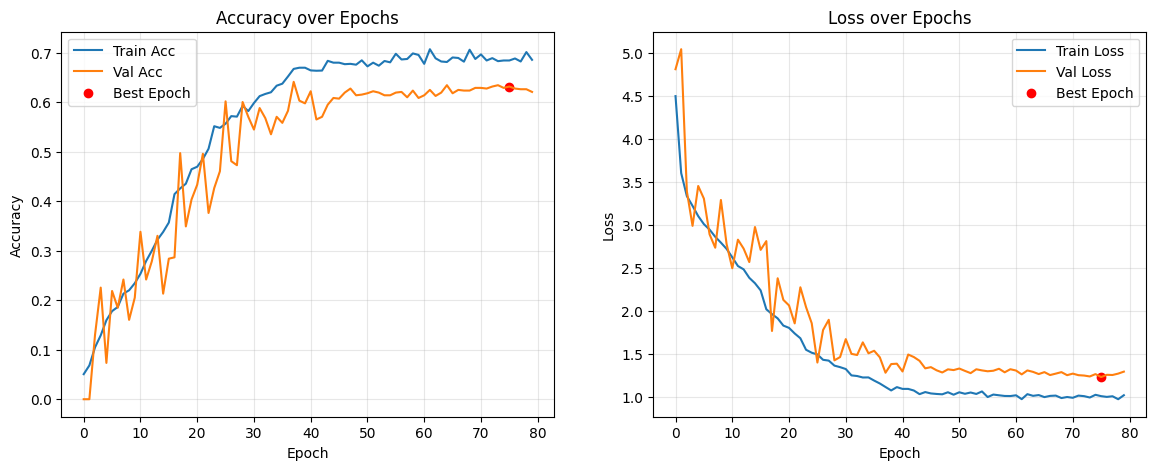

In [ ]:
best_task1 = tf.keras.models.load_model(
    task1_best_path,
    custom_objects={'PetClassifier': PetClassifier} 
)
print("Best task 1 model loaded:", best_task1.name)

best_task1.summary()

plot_model_history(task1_best_history_path)

Loading the best model from task 2 (the one from phase 2) and visualizing both models from both phases for a comparison.

Task 2 part 1 model: pet_classifier
--- Best Model Results ---
Best Epoch: 135
Val Loss: 0.1938
Val Accuracy: 94.29%
Train Loss: 0.5906
Train Accuracy: 81.18%


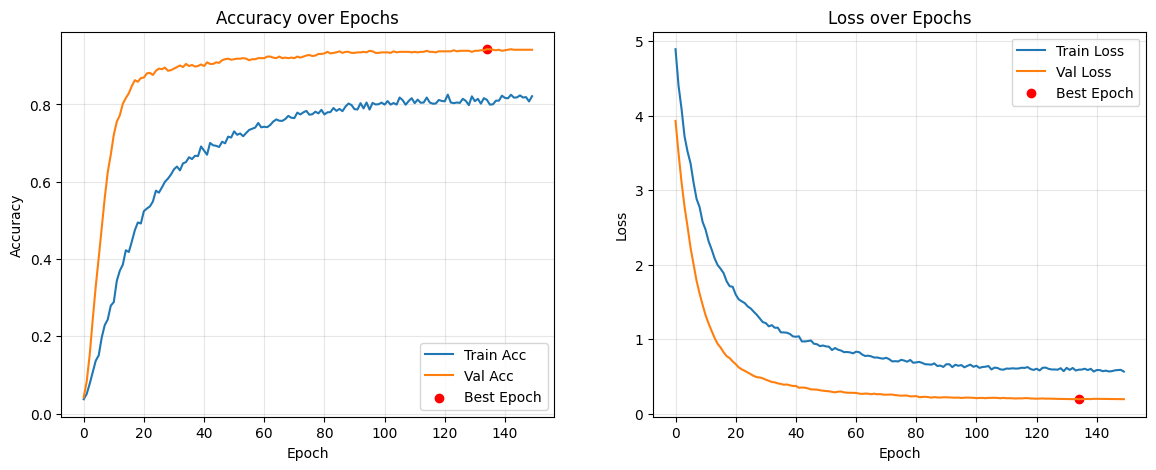

Task 2 part 2 model: pet_classifier
--- Best Model Results ---
Best Epoch: 27
Val Loss: 0.1024
Val Accuracy: 96.33%
Train Loss: 0.1895
Train Accuracy: 93.31%


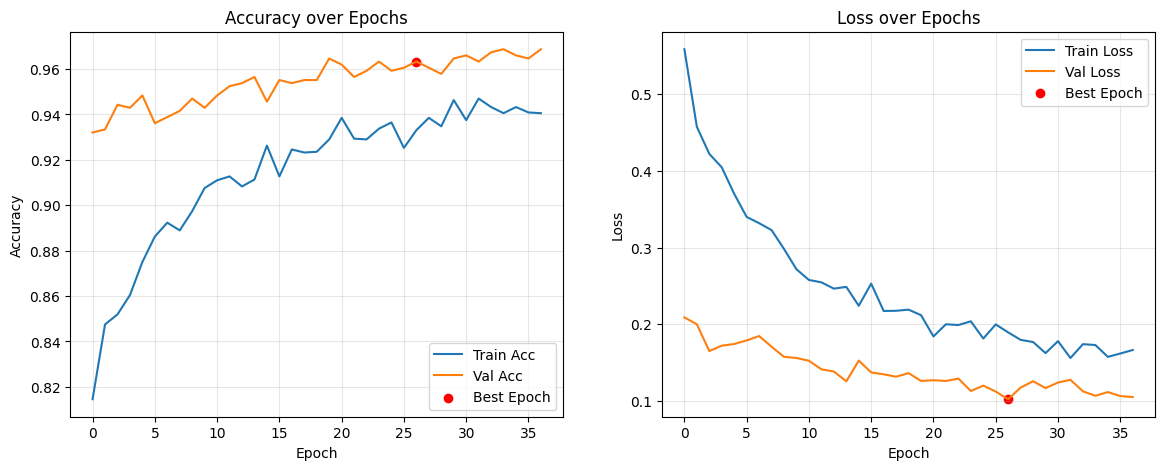

Model: "resnet18_task2_p1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 model_1 (Functional)        (None, 7, 7, 512)         11186889  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 37)                18981     
                                                 

In [ ]:

print("Task 2 part 1 model:")
plot_model_history(task2_p1_best_history_path)

print("Task 2 part 2 model:")
plot_model_history(task2_p2_best_history_path)

best_task2 = tf.keras.models.load_model(task2_p2_best_path)
best_task2.summary()    # on the summary is called "resnet18_task2_p1" being a fine-tuning of part 1, altough it should be just resnet18_task2

## Hyperparameters Configuration

I defined the parameters for the evaluation phase.
<ul>
    <li><b>Image Size</b>: Strictly maintained at <code>(224, 224)</code> to ensure compatibility with the input shape expected by the trained models.</li>
    <li><b>Batch Size</b>: Set to <code>32</code>. Since the evaluation phase involves only forward propagation (inference) without gradient computation, the memory footprint is significantly lower. This allows for efficient processing with a lighter computational load compared to training.</li>
</ul>

In [ ]:
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32       

## Test Set Loading

We load the testing data using <code>image_dataset_from_directory</code> from the <code>test</code> path.

Unlike training, <code>shuffle=False</code> is often preferred during evaluation to map predictions back to filenames easily, though metrics calculation works regardless.


In [ ]:
# preprocessing for test set of task 1: it just needs normalization
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False           # no need for seed if shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
print("Creating Testing Dataset for Task 1...")
test_ds_task1 = (
    test_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE) # Qui usiamo la tua funzione
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

print("Creating Testing Dataset for Task 2...")
test_ds_task2 = (
    test_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 3669 files belonging to 37 classes.
Creating Testing Dataset for Task 1...
Creating Testing Dataset for Task 2...


## Comparative Evaluation on Test Set

The final step is to assess the generalization capability of both models on unseen data (test set).

We use the <code>.evaluate()</code> method, which computes the loss and accuracy over the entire testing dataset.
<ul>
    <li><b>Custom Model (Task 1)</b>: Expected to yield an accuracy around <b>60-63%</b>.</li>
    <li><b>Fine-Tuning (Task 2)</b>: Expected to perform significantly better (target <b>96-97%</b>) due to the pre-learned features from ImageNet.</li>
</ul>

In [ ]:
print("Start evaluating model from Task 1 (Custom Model)...")
# evaluate returns [loss, accuracy]
score_task1 = best_task1.evaluate(test_ds_task1, verbose=1)

print("\nStart evaluating model from Task 2 (Fine-Tuning) ---")
score_task2 = best_task2.evaluate(test_ds_task2, verbose=1)

# --- Creiamo una tabella riassuntiva finale ---
results_table = pd.DataFrame({
    'Metric': ['Loss', 'Accuracy'],
    'Task 1': [score_task1[0], score_task1[1]],
    'Task 2': [score_task2[0], score_task2[1]]
})

print("\n\n=== FINAL ASSESSMENT ===")
print(results_table)

# Piccolo check automatico su chi ha vinto
winner = "Task 2" if score_task2[1] > score_task1[1] else "Task 1"
diff = abs(score_task2[1] - score_task1[1]) * 100
print(f"\nBest model is : {winner} with an advantage of {diff:.2f}%")

Start evaluating model from Task 1 (Custom Model)...
115/115 [==============================] - 3s 30ms/step - loss: 2.6447 - accuracy: 0.3241

Start evaluating model from Task 2 (Fine-Tuning) ---
115/115 [==============================] - 4s 37ms/step - loss: 0.4676 - accuracy: 0.8618


=== FINAL ASSESSMENT ===
     Metric    Task 1    Task 2
0      Loss  2.644685  0.467580
1  Accuracy  0.324066  0.861815

Best model is : Task 2 with an advantage of 53.77%


## Final Assessment and Conclusion

I aggregated the results into a summary table to directly compare the two approaches.

<ul>
    <li><b>Accuracy Gap</b>: The comparison highlights the superior performance of <b>Fine-Tuning</b>. The ResNet-18 model, having seen millions of images during its pre-training, extracts far more robust features than our custom CNN trained from scratch on a small dataset.</li>
    <li><b>Efficiency</b>: While the custom model is lighter, the fine-tuned model provides a much better trade-off between performance and training time (since it converged faster in terms of epochs needed to reach high accuracy).</li>
</ul>

The evaluation on the held-out **Test Set** reveals a performance drop compared to the metrics observed during the training/validation phase. Specifically:
<ul>
    <li><b>Task 1 (Custom Model)</b>: Shows a significant drop (30%), indicating that while the model learned the training distribution, it struggled to generalize to completely unseen data. This is expected for a custom architecture trained from scratch on a small dataset without pre-trained priors.</li>
    <li><b>Task 2 (Fine-Tuning)</b>: Shows a more contained drop (10%, from 96% to 86%). While the model is highly robust, this gap suggests some degree of overfitting to the specific characteristics of the validation split.</li>
</ul>

<b>Conclusion:</b>
Despite the drop, the <b>86% accuracy</b> on the Test Set for the Fine-Tuned model remains a strong result, confirming the effectiveness of Fine-Tuning compared to the Custom CNN.